<a href="https://colab.research.google.com/github/jtao22/PythonML/blob/main/stockprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
#Import
import numpy as np
import pandas_datareader as pdr
import math
import datetime
import matplotlib.pyplot as pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler as mms
from keras.layers import Dense, LSTM
from keras.models import Sequential
pyplot.style.use('fivethirtyeight')


In [88]:
#Retrieve data
#startdate = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%m-%d-%Y")
data = pdr.DataReader('MSFT', data_source="yahoo", start = "2010-1-1")
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,31.100000,30.590000,30.620001,30.950001,38409100.0,24.105360
2010-01-05,31.100000,30.639999,30.850000,30.959999,49749600.0,24.113148
2010-01-06,31.080000,30.520000,30.879999,30.770000,58182400.0,23.965164
2010-01-07,30.700001,30.190001,30.629999,30.450001,50559700.0,23.715933
2010-01-08,30.879999,30.240000,30.280001,30.660000,51197400.0,23.879499
...,...,...,...,...,...,...
2021-01-04,223.000000,214.809998,222.529999,217.690002,37113600.0,217.690002
2021-01-05,218.520004,215.699997,217.259995,217.899994,23800200.0,217.899994
2021-01-06,216.490005,211.940002,212.169998,212.250000,35883400.0,212.250000


In [89]:
#filter data, convert to array
newdata = data.filter(['Close'])
dataset = newdata.values
#set variables
traindatalength = math.ceil(len(dataset)*0.8)
#scale data
scaler = mms(feature_range=(0,1))
scaled = scaler.fit_transform(dataset)

In [90]:
#create data to train architecture
train = scaled[0:traindatalength, :]
trainX = [] #independent
trainY = [] #dependent
for i in range(30,len(train)):
  trainX.append(train[i-30:i,0])
  trainY.append(train[i,0])
#convert data into numpy array
trainX = np.array(trainX)
trainY = np.array(trainY)
#fit dimensions for LSTM
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],1))

In [91]:
#build LSTM architecture
arch = Sequential()
arch.add(LSTM(50, return_sequences = True, input_shape = (trainX.shape[1],1)))
arch.add(LSTM(50, return_sequences = False))
arch.add(Dense(25))
arch.add(Dense(1))
#compile
arch.compile(optimizer='adam', loss = 'mean_squared_error')

In [92]:
#train architecture
arch.fit(trainX, trainY, batch_size = 1, epochs = 1)


2190/2190 [==============================] - 31s 13ms/step - loss: 7.7318e-04


In [93]:
#make test data
test = scaled[traindatalength-30: , :]
testX = []
testY = dataset[traindatalength:, :]
for i in range(30,len(test)):
  testX.append(test[i-30:i,0])
#convert data into numpy array
testX = np.array(testX)
#fit dimensions for LSTM 
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [94]:
#run
predictions = arch.predict(testX)
predictions = scaler.inverse_transform(predictions)
#RMSE
rmse = np.sqrt(np.mean(np.power((np.array(testY)-np.array(predictions)),2)))
rmse

7.042550640657758

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


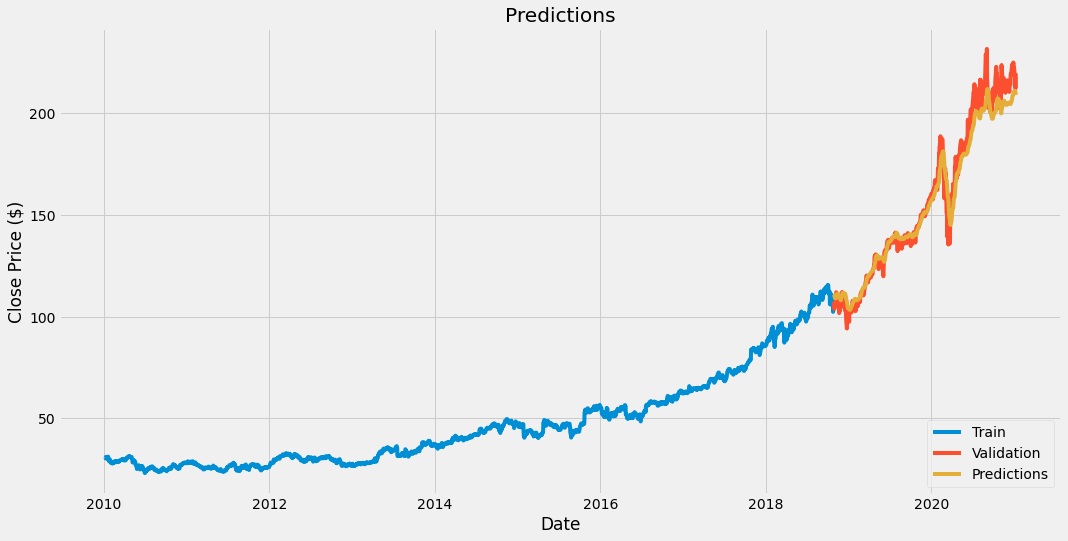

In [95]:
#visualize
traindata = newdata[:traindatalength]
valid = newdata[traindatalength:]
valid['Predictions'] = predictions
pyplot.figure(figsize=(16,8))
pyplot.title('Predictions')
pyplot.xlabel('Date', fontsize=17)
pyplot.ylabel ('Close Price ($)', fontsize=17)
pyplot.plot(traindata['Close'])
pyplot.plot(valid[['Close', 'Predictions']])
pyplot.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
pyplot.show()

In [96]:
valid

,Close,Predictions
Date,,
2018-10-26,106.959999,111.022110
2018-10-29,103.849998,110.708290
2018-10-30,103.730003,110.187897
2018-10-31,106.809998,109.594292
2018-11-01,105.919998,109.289116
...,...,...
2021-01-04,217.690002,211.030502
2021-01-05,217.899994,210.814865
2021-01-06,212.250000,210.429398


In [97]:
#Get quote to predict different price, filter data
SNP = pdr.DataReader('MSFT', data_source="yahoo",start='2010-01-01', end='2020-12-31')
new_data = SNP.filter(['Close'])
past_two_months = new_data[-60:].values
past_two_months_scaled = scaler.transform(past_two_months)


In [98]:
Xtest = []
Xtest.append(past_two_months_scaled)
#convert to numpy array
Xtest = np.array(Xtest)
#fit dimensions for LSTM 
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1],1))

In [99]:
#run
predicted = arch.predict(Xtest)
predicted = scaler.inverse_transform(predicted)
print(predicted)

[[211.07092]]
